# Tutorial

Demonstração da utilização dos <a href="https://transparencia.sns.gov.pt/explore/?sort=title">dados disponibilizados</a> pelo <a href="https://www.sns.gov.pt/">Serviço Nacional de Saúde</a>.

O objectivo deste notebook é:

* Mostrar como obter dados utilizando a <a href="https://transparencia.sns.gov.pt/api/v1/console/datasets/1.0/search/">API</a> disponibilizada pela área de <a href="https://www.sns.gov.pt/transparencia/">Transparência do Portal do Serviço Nacional de Saúde</a>;
* Ilustrar o processo de limpeza e visualização destes dados;
* Explorar o impacto do  COVID-19 na sociedade em geral e em particular na prestação de cuidados de saúde em Portugal com questões como:
    * Como foi afectada a prestação de cuidados de oncologia?
    * Como foram afectadas as cirugias? 
    * Que impacto teve na mortalidade total em comparação com outros anos?
    * Qual o impacto da covid nas consultas médicas hospitalares e consultas em Telemedicina?
    * Como evoluiu a mobilidade dos portugueses com o aumento da fadiga pandémica? 
    * Qual o peso das condições meteorológicas na mobilidade?    
    * ...

## O que é uma API?

Os dados do portal estão disponíveis na internet para que qualquer pessoa possa encontrar, ver e descarregar os dados que pretende.

Uma API permite que um programa consiga facilmente efetuar as mesmas operações.

## Que operações estão disponíveis?

Existem neste momento duas versões da API cuja documentação pode ser consultada: a <a href="https://transparencia.sns.gov.pt/api/v1/console/datasets/1.0/search/">versão 1.0</a> e a <a href="https://transparencia.sns.gov.pt/api/v2/console">nova versão 2.0</a> que ainda está em desenvolvimento.

Ambas permitem procurar *datasets* conjuntos de dados sobre um tema específico, obter dados, procurar dados com características específicas e até efetuar algumas operações sobre os dados, por exemplo agrupá-los por ano, ou localização.

No âmbito deste tutorial, vamos utilizar a biblioteca **odsclient** que nos permite facilmente aceder aos dados do portal, **numpy** e **pandas** para manipular os dados, e para as visualizações vamos utilizar **seaborn** e **matplotlib**.

## Instalação de bibliotecas

A instalação das bibliotecas necessárias é muito simples:

Carregar as bibliotecas e algumas funções que vamos usar.

* `get_df_from_url` : descarrega um dataset que esteja disponível online como json
* `get_month_labels_from_date_columns`: cria labels como "Jan-2020" a partir de colunas do tipo datetime que vamos criar com os pivots mais abaixo.

In [1]:
%matplotlib inline

from calendar import month_abbr
from datetime import datetime
import re
import requests

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FixedLocator
import numpy as np
from odsclient import get_whole_dataframe
import pandas as pd
import seaborn as sns


def get_df_from_url(url):
    response = requests.get(url)
    return pd.read_json(response.text)

def get_month_labels_from_date_columns(df):
    return [f"{month_abbr[dt.month]}-{dt.year}" for dt in df.columns]
    

# 1 - Consultas Médicas Hospitalares

Vamos olhar para os dados disponibilizados sobre <a href="https://transparencia.sns.gov.pt/explore/dataset/01_sica_evolucao-mensal-das-consultas-medicas-hospitalares">Consultas Médicas Hospitalares</a>


## 1.1 Obter os dados com odsclient

Na <a href="https://transparencia.sns.gov.pt/explore/dataset/01_sica_evolucao-mensal-das-consultas-medicas-hospitalares/api/?sort=periodo">tab API </a> do nosso dataset podemos encontrar o nome do dataset **01_sica_evolucao-mensal-das-consultas-medicas-hospitalares** e com ele podemos obter os dados prontos a tratar como um pandas `DataFrame`:


In [2]:
df_hosp = get_whole_dataframe("01_sica_evolucao-mensal-das-consultas-medicas-hospitalares", 
                              base_url="https://transparencia.sns.gov.pt/", tqdm=True)
df_hosp.head()

https://transparencia.sns.gov.pt/explore/dataset/01_sica_evolucao-mensal-das-consultas-medicas-hospitalares/download/: 0.00B [00:02, ?B/s]


,Período,Periodo_format_2,Região,Instituição,Localização Geográfica,Nº Consultas Médicas Total,Nº Primeiras Consultas,Nº Consultas Subsequentes
0,2013-01,2013/01/01,Região de Saúde do Alentejo,"Unidade Local de Saúde do Baixo Alentejo, EPE","38.014123,-7.8721227",8443,2753,5690
1,2013-01,2013/01/01,Região de Saúde do Centro,"Centro Hospitalar do Baixo Vouga, EPE","40.6362453,-8.6543716",19526,6422,13104
2,2013-01,2013/01/01,Região de Saúde LVT,Centro Hospitalar Psiquiátrico de Lisboa,"38.7569771,-9.1460705",5940,444,5496
3,2013-01,2013/01/01,Região de Saúde LVT,"Hospital Professor Doutor Fernando Fonseca, EPE","38.7422257,-9.2264834",25665,6855,18810
4,2013-01,2013/01/01,Região de Saúde LVT,"Hospital Garcia de Orta, EPE","38.6658713,-9.1822554",24763,7058,17705


## 1.2 Distribuição das instituições por  região

Para começar, quantas instituições existem e a que regiões pertencem?

,Instituição
Região,
Região de Saúde LVT,17
Região de Saúde Norte,18
Região de Saúde do Alentejo,4
Região de Saúde do Algarve,1
Região de Saúde do Centro,13


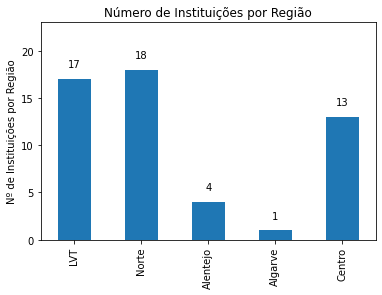

In [4]:
df_num_inst = df_hosp[['Região', 'Instituição']].groupby('Região').nunique()
display(df_num_inst)

ax = df_num_inst.plot(kind='bar')
ax.set_title('Número de Instituições por Região');
ax.set_ylabel('Nº de Instituições por Região');
ax.set_xlabel('');
ax.get_legend().remove()
ax.set_xticklabels([região.split()[-1] for região in df_num_inst.index], rotation=90);
ax.set_ylim(0,23)
bars = ax.patches

for bar, value in zip(bars, df_num_inst.Instituição.values):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, value, ha='center', va='bottom')


# TODO
- Cruzar dados com densidade populacional / região

## 1.3 Distribuição das consultas por instituição

Para obter uma primeira ideia dos dados iremos analisar a variabilidade do número de consultas em cada instituição e região:

In [55]:
df_grouped = df_hosp.groupby(['Região','Instituição']).agg({'Período' : ['min', 'max', 'count'],
                                               'Nº Consultas Médicas Total':['sum', 'min', 'max', 'mean','std']}).copy()
df_grouped

Período  \
                                                                                    min   
Região                      Instituição                                                   
Região de Saúde LVT         Centro Hospitalar Barreiro/Montijo, EPE             2013-01   
                            Centro Hospitalar Médio Tejo, EPE                   2013-01   
                            Centro Hospitalar Psiquiátrico de Lisboa            2013-01   
                            Centro Hospitalar Universitário Lisboa Central,...  2013-01   
                            Centro Hospitalar Universitário de Lisboa Norte...  2013-01   
                            Centro Hospitalar de Lisboa Ocidental, EPE          2013-01   
                            Centro Hospitalar de Setúbal, EPE                   2013-01   
                            Centro Hospitalar do Oeste, EPE                     2013-01   
                            Hospital Distrital de Santarém, EPE                 2013-01   
                            Hospital Garcia de Orta, EPE                        2013-01   
                            Hospital Professor Doutor Fernando Fonseca, EPE     2013-01   
                            Hospital de Cascais, PPP                            2013-01   
                            Hospital de Loures, PPP                             2013-01   
                            Hospital de Vila Franca de Xira, EPE                2021-06   
                            Hospital de Vila Franca de Xira, PPP                2013-01   
                            Instituto Gama Pinto                                2013-01   
                            Instituto Português Oncologia de Lisboa, EPE        2013-01   
Região de Saúde Norte       Centro Hospitalar Entre Douro e Vouga, EPE          2013-01   
                            Centro Hospitalar Póvoa de Varzim/Vila do Conde...  2013-01   
                            Centro Hospitalar Trás-os-Montes e Alto Douro, EPE  2013-01   
                            Centro Hospitalar Tâmega e Sousa, EPE               2013-01   
                            Centro Hospitalar Universitário de São João, EPE    2013-01   
                            Centro Hospitalar Universitário do Porto, EPE       2013-01   
                            Centro Hospitalar Vila Nova de Gaia/Espinho, EPE    2013-01   
                            Centro Hospitalar do Alto Ave, EPE                  2013-01   
                            Centro Hospitalar do Médio Ave, EPE                 2013-01   
                            Hospital Santa Maria Maior, EPE                     2013-01   
                            Hospital da Senhora da Oliveira, Guimarães, EPE     2015-01   
                            Hospital de Braga, EPE                              2019-09   
                            Hospital de Braga, PPP                              2013-01   
                            Hospital de Magalhães Lemos, EPE                    2013-01   
                            Instituto Português Oncologia do Porto, EPE         2013-01   
                            Unidade Local de Saúde de Matosinhos, EPE           2013-01   
                            Unidade Local de Saúde do Alto Minho, EPE           2013-01   
                            Unidade Local de Saúde do Nordeste, EPE             2013-01   
Região de Saúde do Alentejo Hospital Espírito Santo de Évora, EPE               2013-01   
                            Unidade Local de Saúde do Baixo Alentejo, EPE       2013-01   
                            Unidade Local de Saúde do Litoral Alentejano, EPE   2013-01   
                            Unidade Local de Saúde do Norte Alentejano, EPE     2013-01   
Região de Saúde do Algarve  Centro Hospitalar Universitário do Algarve,EPE      2013-01   
Região de Saúde do Centro   Centro Hospitalar Tondela-Viseu, EPE                2013-01   
                            Centro Hospitalar Universitário Cova da Beira, E

Da análise desta tabela observamos:

* Os dados são entre Janeiro de 2013 e Julho de 2021, mas nem todas as instituições têm todos os meses

In [56]:
df_grouped[df_grouped.loc[:, ('Período', 'count')] != 103]

Período  \
                                                                               min   
Região                    Instituição                                                
Região de Saúde LVT       Hospital de Vila Franca de Xira, EPE             2021-06   
                          Hospital de Vila Franca de Xira, PPP             2013-01   
Região de Saúde Norte     Centro Hospitalar do Alto Ave, EPE               2013-01   
                          Hospital da Senhora da Oliveira, Guimarães, EPE  2015-01   
                          Hospital de Braga, EPE                           2019-09   
                          Hospital de Braga, PPP                           2013-01   
Região de Saúde do Centro Hospital Arcebispo João Crisóstomo               2013-01   
                          Hospital José Luciano de Castro                  2013-01   

                                                                                    \
                                                                               max   
Região                    Instituição                                                
Região de Saúde LVT       Hospital de Vila Franca de Xira, EPE             2021-07   
                          Hospital de Vila Franca de Xira, PPP             2021-05   
Região de Saúde Norte     Centro Hospitalar do Alto Ave, EPE               2014-12   
                          Hospital da Senhora da Oliveira, Guimarães, EPE  2021-07   
                          Hospital de Braga, EPE                           2021-07   
                          Hospital de Braga, PPP                           2019-08   
Região de Saúde do Centro Hospital Arcebispo João Crisóstomo               2021-05   
                          Hospital José Luciano de Castro                  2014-12   

                                                                                 \
                                                                          count   
Região                    Instituição                                             
Região de Saúde LVT       Hospital de Vila Franca de Xira, EPE                2   
                          Hospital de Vila Franca de Xira, PPP              101   
Região de Saúde Norte     Centro Hospitalar do Alto Ave, EPE                 24   
                          Hospital da Senhora da Oliveira, Guimarães, EPE    79   
                          Hospital de Braga, EPE                             23   
                          Hospital de Braga, PPP                             80   
Região de Saúde do Centro Hospital Arcebispo João Crisóstomo                101   
                          Hospital José Luciano de Castro                    24   

                                                                          Nº Consultas Médicas Total  \
                                                                                                 sum   
Região                    Instituição                                                                  
Região de Saúde LVT       Hospital de Vila Franca de Xira, EPE                                164879   
                          Hospital de Vila Franca de Xira, PPP                               7777167   
Região de Saúde Norte     Centro Hospitalar do Alto Ave, EPE                                 3308126   
                          Hospital da Senhora da Oliveira, Guimarães, EPE                   10636758   
                          Hospital de Braga, EPE                                             5644537   
                          Hospital de Braga, PPP                                            18142017   
Região de Saúde do Centro Hospital Arcebispo João Crisóstomo                                  925008   
                          Hospital José Luciano de Castro                                     163011   

                                                                                  \
                                      

In [60]:
df_grouped = df_grouped.reset_index(drop=False)

Região  \
                                  
0           Região de Saúde LVT   
1           Região de Saúde LVT   
2           Região de Saúde LVT   
3           Região de Saúde LVT   
4           Região de Saúde LVT   
5           Região de Saúde LVT   
6           Região de Saúde LVT   
7           Região de Saúde LVT   
8           Região de Saúde LVT   
9           Região de Saúde LVT   
10          Região de Saúde LVT   
11          Região de Saúde LVT   
12          Região de Saúde LVT   
13          Região de Saúde LVT   
14          Região de Saúde LVT   
15          Região de Saúde LVT   
16          Região de Saúde LVT   
17        Região de Saúde Norte   
18        Região de Saúde Norte   
19        Região de Saúde Norte   
20        Região de Saúde Norte   
21        Região de Saúde Norte   
22        Região de Saúde Norte   
23        Região de Saúde Norte   
24        Região de Saúde Norte   
25        Região de Saúde Norte   
26        Região de Saúde Norte   
27        Região de Saúde Norte   
28        Região de Saúde Norte   
29        Região de Saúde Norte   
30        Região de Saúde Norte   
31        Região de Saúde Norte   
32        Região de Saúde Norte   
33        Região de Saúde Norte   
34        Região de Saúde Norte   
35  Região de Saúde do Alentejo   
36  Região de Saúde do Alentejo   
37  Região de Saúde do Alentejo   
38  Região de Saúde do Alentejo   
39   Região de Saúde do Algarve   
40    Região de Saúde do Centro   
41    Região de Saúde do Centro   
42    Região de Saúde do Centro   
43    Região de Saúde do Centro   
44    Região de Saúde do Centro   
45    Região de Saúde do Centro   
46    Região de Saúde do Centro   
47    Região de Saúde do Centro   
48    Região de Saúde do Centro   
49    Região de Saúde do Centro   
50    Região de Saúde do Centro   
51    Região de Saúde do Centro   
52    Região de Saúde do Centro   

                                          Instituição  Período                 \
                                                           min      max count   
0             Centro Hospitalar Barreiro/Montijo, EPE  2013-01  2021-07   103   
1                   Centro Hospitalar Médio Tejo, EPE  2013-01  2021-07   103   
2            Centro Hospitalar Psiquiátrico de Lisboa  2013-01  2021-07   103   
3   Centro Hospitalar Universitário Lisboa Central...  2013-01  2021-07   103   
4   Centro Hospitalar Universitário de Lisboa Nort...  2013-01  2021-07   103   
5          Centro Hospitalar de Lisboa Ocidental, EPE  2013-01  2021-07   103   
6                   Centro Hospitalar de Setúbal, EPE  2013-01  2021-07   103   
7                     Centro Hospitalar do Oeste, EPE  2013-01  2021-07   103   
8                 Hospital Distrital de Santarém, EPE  2013-01  2021-07   103   
9                        Hospital Garcia de Orta, EPE  2013-01  2021-07   103   
10    Hospital Professor Doutor Fernando Fonseca, EPE  2013-01  2021-07   103   
11                           Hospital de Cascais, PPP  2013-01  2021-07   103   
12                            Hospital de Loures, PPP  2013-01  2021-07   103   
13               Hospital de Vila Franca de Xira, EPE  2021-06  2021-07     2   
14               Hospital de Vila Franca de Xira, PPP  2013-01  2021-05   101   
15                               Instituto Gama Pinto  2013-01  2021-07   103   
16       Instituto Português Oncologia de Lisboa, EPE  2013-01  2021-07   103   
17         Centro Hospitalar Entre Douro e Vouga, EPE  2013-01  2021-07   103   
18  Centro Hospitalar Póvoa de Varzim/Vila do Cond...  2013-01  2021-07   103   
19  Centro Hospitalar Trás-os-Montes e Alto Douro,...  2013-01  2021-07   103   
20              Centro Hospitalar Tâmega e Sousa, EPE  2013-01  2021-07   103   
21   Centro Hospitalar Universitário de São João, EPE  2013-01  2021-07   103   
22      Centro Hospitalar Universitário do Porto, EPE  2013-01  2021-07   103   
23   Centro Hospitalar Vila Nova de Gaia/Espinho, EPE  2013-01  2021-07   

In [57]:
old_name_map = {
    "Hospital de Vila Franca de Xira, PPP": "Hospital de Vila Franca de Xira, EPE",
    "Centro Hospitalar do Alto Ave, EPE": "Hospital da Senhora da Oliveira, Guimarães, EPE",
    "Hospital de Braga, PPP": "Hospital de Braga, EPE"
}

df_grouped["x"] = df_grouped["Instituição"].applymap(old_name_map)

KeyError: 'Instituição'

Continuando com a nossa análise:
* O número mínimo de consultas médicas é muito menor quer que a média
* O desvio padrão é muito maior que o valor mínimo
* Isto acontece de forma consistente para todas as instituições
* Focando num único hospital, por exemplo o IPO em Lisboa:
  * O IPO tem <a href="https://www.ipolisboa.min-saude.pt/ipo/conheca-nos/">360 médicos</a>
  * Nem todos os médicos do IPO trabalham em exclusividade, nem dão consultas todos os dias
  * Os médicos têm férias, outros deveres além das consultas e têm de ter algumas pausas durante o dia
  * O máximo mensal para o IPO em Lisboa é de 274.815 consultas de oncologia num mês, com uma média 22 dias úteis por mês dá mais de 34 consultas por médico por dia, o que parece claramente excessivo.
  * Já o mínimo de 20.678 dá cerca de 3 consultas por médico por dia, o que faz mais sentido atendendo a que nem todos os médicos dão consultas todos os dias, e que algumas consultas são bastante demoradas.

Vamos olhar para os dados de uma instituição a ver conseguimos identificar a causa:

C:\Users\pmiguere\.conda\envs\machine_learning\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


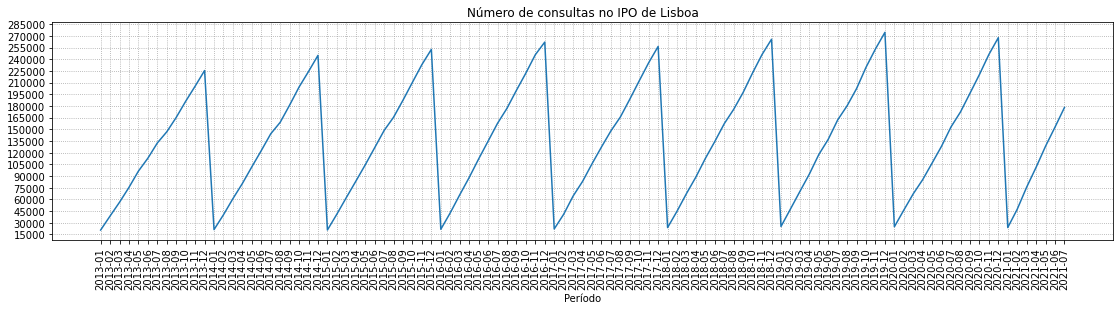

In [6]:
instituição = 'Instituto Português Oncologia de Lisboa, EPE'
df = df_hosp[df_hosp.Instituição==instituição].sort_values('Período').set_index('Período', drop=False)
ax=df['Nº Consultas Médicas Total'].plot(figsize=(19,4));
ax.set_xticks(range(len(df["Período"])))
ax.set_xticklabels(df["Período"], rotation=90);
ax.set_title('Número de consultas no IPO de Lisboa');
ax.yaxis.set_major_locator(MultipleLocator(15000))
ax.grid(which='major', color='#A0A0A0', linestyle=':')

Analizando o gráfico compreende-se que:

* O número de consultas mensal é cumulativo ao longo de cada ano
* O total de consultas em 2020 no IPO mostra apenas um ligeiro decréscimo face ao ano anterior apesar da pandemia

Vamos ver se o mesmo acontece nas restantes instituições:

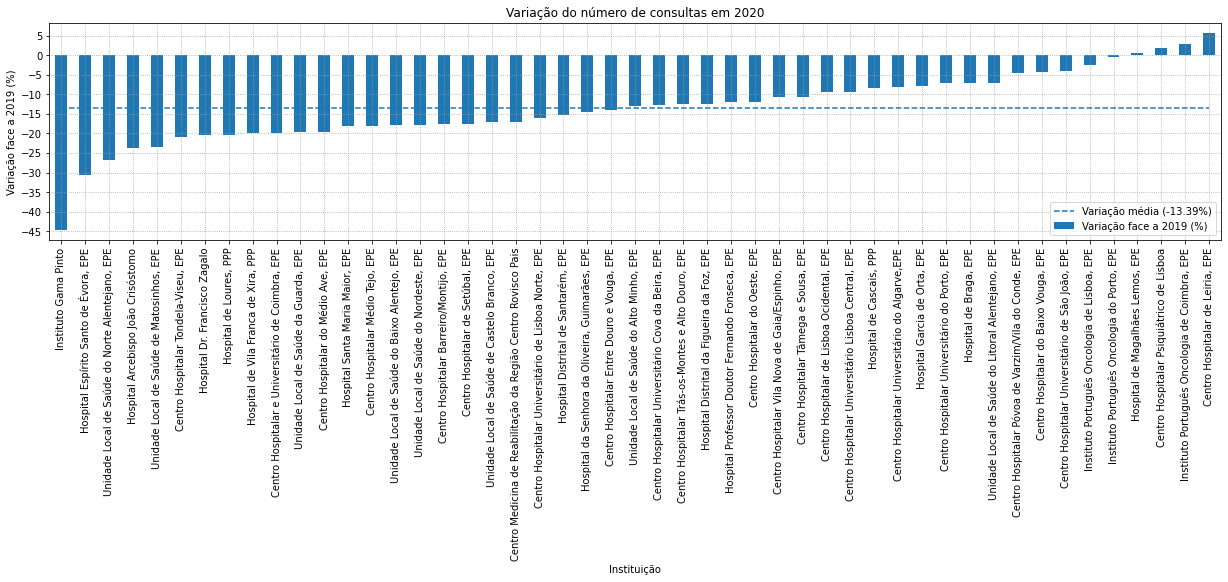

In [25]:
nome = 'Variação face a 2019 (%)'
df = df_hosp.copy()

df = df_hosp[['Período','Nº Consultas Médicas Total','Instituição']].copy().set_index('Instituição')
df = 100*(df[(df.Período=='2020-12')][['Nº Consultas Médicas Total']] - df[df.Período=='2019-12'][['Nº Consultas Médicas Total']])/df[df.Período=='2020-12'][['Nº Consultas Médicas Total']]
df.columns=[nome]

df.sort_values(by=nome, inplace=True)
ax = df.plot(figsize=(21,4), kind='bar')
ax.set_title('Variação do número de consultas em 2020');
ax.set_ylabel('Variação face a 2019 (%)');
ax.set_xticks(range(len(df)))
ax.set_xticklabels(df.index, rotation=90);
ax.yaxis.set_major_locator(MultipleLocator(5))
ax.grid(which='major', color='#A0A0A0', linestyle=':')
média =  np.ones(len(df.index))*df[nome].mean()
ax.plot(média, label=f"Variação média ({média[0]:.2f}%)", linestyle='--');
ax.legend(loc='lower right');


Há um decréscimo médio de 13% do número de consultas, embora o impacto seja extremamente variado, desde o Instituto Gama Pinto que fez cerca de metade das consultas que no ano anterior, para CH Leiria que fez mais 5% que no ano anterior.

## 1.4 Evolução mensal do número de consultas

Construir um novo dataframe com as diferenças para o mês anterior, exceto em Janeiro quando devemos manter apenas o valor indicado. Para facilitar vamos focar a atenção nas instituições que têm dados para todos os meses

In [8]:
df_mes = df_hosp.copy()
df_mes['Mês'] = pd.to_datetime(df_mes['Período'] , format='%Y-%m')  
df_mes['Dia'] = pd.to_datetime(df_mes['Periodo_format_2'] , format='%Y/%m/%d')

df_inst_completas = df_mes[['Instituição','Mês']].groupby('Instituição').nunique()
all_inst = len(df_inst_completas)
df_inst_completas=df_inst_completas[df_inst_completas.Mês==df_inst_completas.Mês.max()].index
df_mes = df_mes[df_mes.Instituição.isin(df_inst_completas)]
print(f"Existem {all_inst} instituições das quais vamos usar as {df_mes.Instituição.nunique()} que têm dados para todos os meses.")

Existem 53 instituições das quais vamos usar as 45 que têm dados para todos os meses.


Para estas 47 instituições vamos olhar para as consultas desde 2019 e ver se notamos algum padrão nas consultas mensais.

O código é um pouco complexo, mas a ideia geral é acessível:
* Começamos por criar `pivot_mes` que tem:
  * colunas que são datas, ex: 2019-01-01, 2019-02-01, ... 2019-12-01, 2020-02-01,...
  * linhas são as instituições que têm dados em todos os meses
  * os valores são o número de consultas nessa instituição acumuladas anualmente até esse mês
* Vamos usá-lo para  criar `df_inst` que nos valores contém o número de consultas realizadas nessa instituição apenas nesse mês, para isso:
  * Substuímos cada mês pela diferença entre o valor atual e o valor anterior, efetivamente desfazendo os acumulados
  * Em Janeiro de cada ano repomos o valor que estava originalmente em `pivot_mes` porque os acumulados recomeçam anualmente em Janeiro



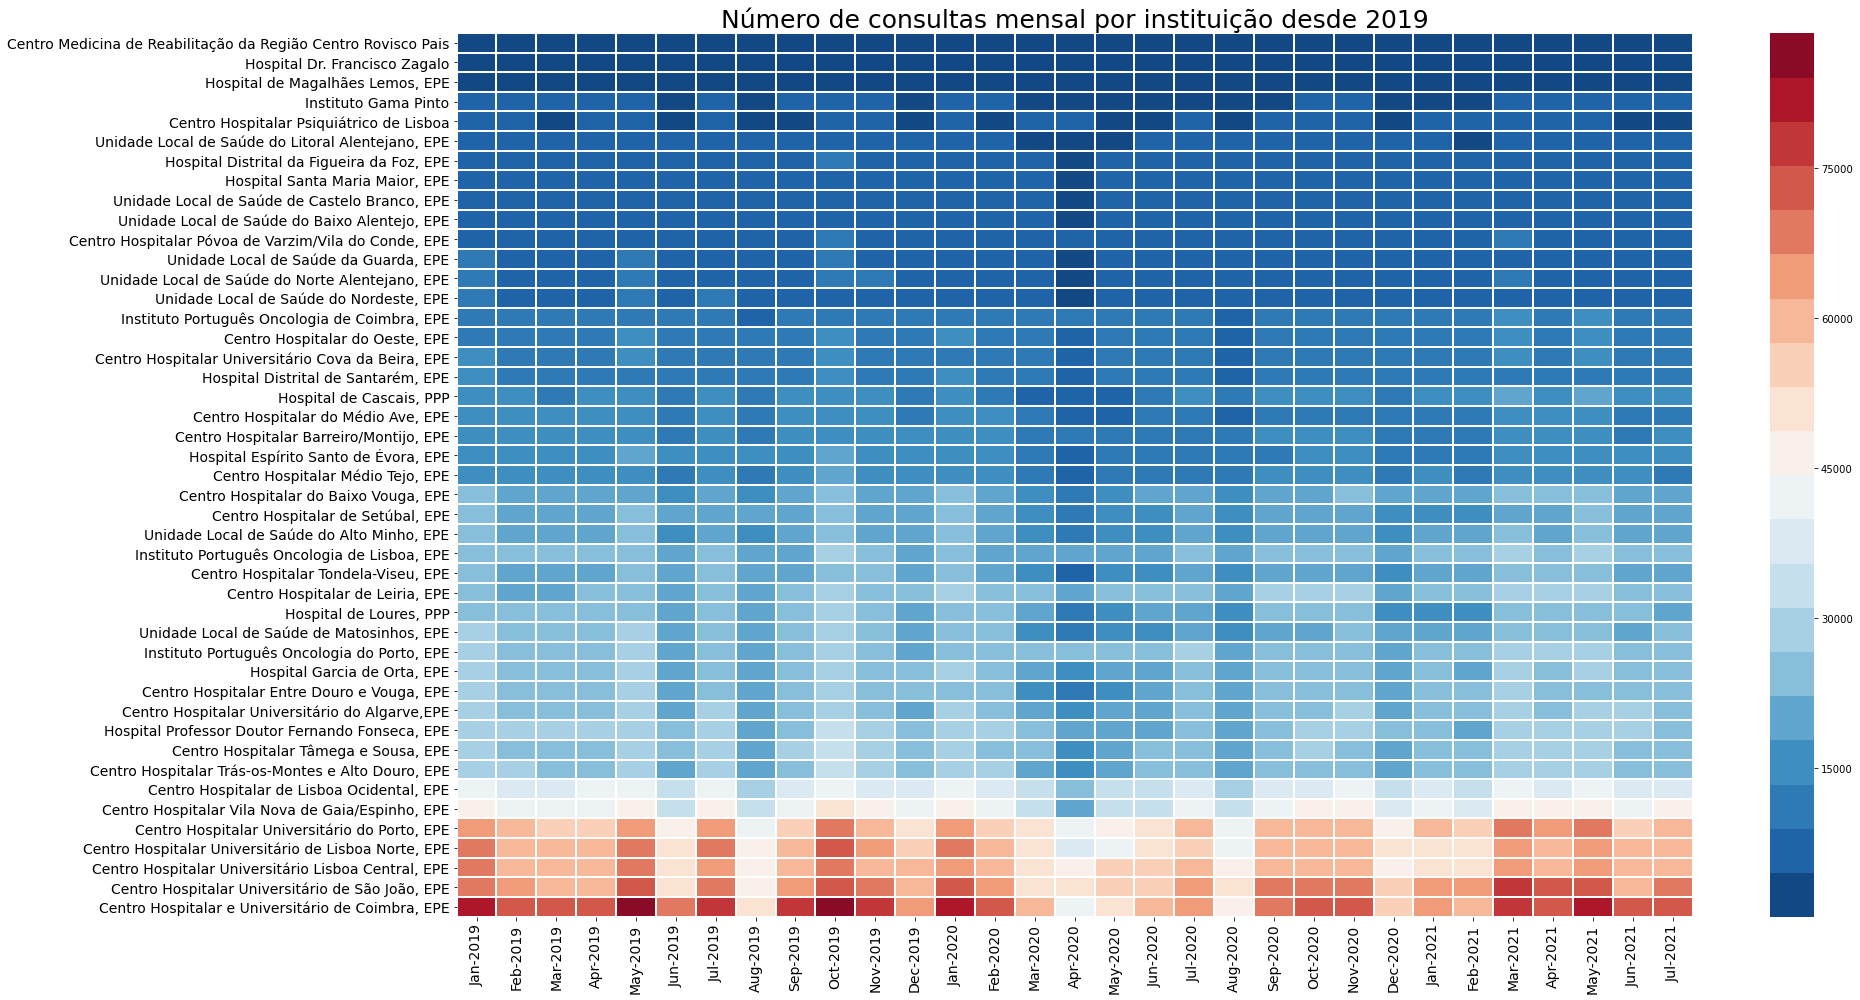

In [9]:
pivot_mes = pd.pivot_table(df_mes, values='Nº Consultas Médicas Total', index=['Instituição'], columns=['Dia'], aggfunc='sum')
df_inst = pivot_mes.T.diff()
df_inst = df_inst.where(df_inst>1).T.iloc[:, 72:]
for i in range(0,len(df_inst.columns),12):
    df_inst.iloc[:,  i] = pivot_mes.iloc[:, 72+i]   # 2019-01-01, 2020-01-01, 2021-01-01, ...
xlabels = get_month_labels_from_date_columns(df_inst)

df_inst.sort_values(by='2019-01-01', inplace=True)
cmap = sns.color_palette('RdBu_r', 20)
fig, ax = plt.subplots(figsize=(28,14))
ax = sns.heatmap(df_inst, square=False, annot=False, cmap = cmap, linewidths=1)
ax.set_yticklabels(df_inst.index,rotation=0, fontsize = 14);
ax.set_xticklabels(xlabels,rotation=90, fontsize = 14);
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title("Número de consultas mensal por instituição desde 2019", fontsize=25);
plt.tight_layout()

Identificam-se: 
* menos consultas em Junho e Agosto, provavelmente efeitos das férias nos feriados de Junho e em Agosto;
* Abril de 2020 foi um mês com poucas consultas especialmente nos grandes hospitais

Os períodos de março, abril e maio de 2020 registam poucas consultas especialmente nos grandes hospitais, como consequência do Estado de Emergência implementado. No final de 2020 verifica-se também uma redução destacada quando se compara com o período homólogo de 2019, sendo mais significativa no “Centro Hospitalar Universitário de São João, EPE” e “Centro Hospitalar Universitário de Coimbra, EPE”.


Vamos ver também comparação dos totais de consultas mensais nos 3 últimos anos: 

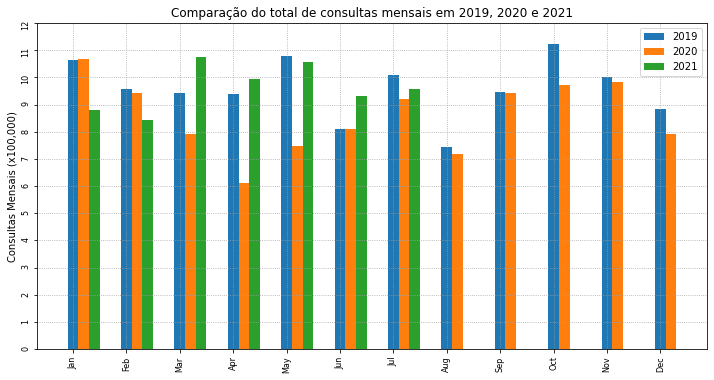

In [10]:
total_mensal = df_inst.sum(axis=0)
total_19 = total_mensal.iloc[:12]
total_20 = total_mensal.iloc[12:24]
total_21 = total_mensal.iloc[24:36]
fig, ax = plt.subplots(figsize=(12,6))
ax.bar(range(0,120,10),total_19.values, width=2, label="2019")
ax.bar(range(2,122,10),total_20.values, width=2, label="2020")
ax.bar(range(4,len(total_21)*10+4,10),total_21.values, width=2, label="2021")
ax.set_xticks(range(0,120,10))
ax.set_xticklabels(month_abbr[1:], rotation=90, fontsize = 8);

step = 100000 
lim = int(step*(2+total_mensal.max()//step))
ticks = list(range(0,lim,step))
ax.set_yticks(ticks)
ax.yaxis.set_major_locator(FixedLocator(ticks))
ax.grid(which='major', color='#A0A0A0', linestyle=':')
ax.set_yticklabels([f"{i//step:,}" for i in ticks], rotation=90, fontsize = 8);
ax.set_ylabel(f'Consultas Mensais (x{step:,})')
ax.legend()
ax.set_title("Comparação do total de consultas mensais em 2019, 2020 e 2021");

As maiores diferenças entre o número de consultas mensais entre 2019 e 2020 registam-se nos meses de março, abril e maio, coincidindo com períodos de Estado de Emergência nacional. O Estado de Emergência foi também implementado nos meses de Novembro e Dezembro de 2020 porém, verifica-se que a redução no nº de consultas não é tão significativa.
Por outro lado, em 2021 observa-se a recuperação progressiva das consultas face aos valores anteriores à situação pandémica.

In [11]:
covid_start_date = '2020-01-01'
before_covid_days = df_mes.loc[df_mes['Dia']<covid_start_date].index
after_covid_days = df_mes.loc[df_mes['Dia']>=covid_start_date].index

# Obter dados do Covid

In [12]:
df_covid = get_df_from_url('https://covid19-api.vost.pt/Requests/get_full_dataset')
df_covid.fillna(0, inplace=True)
df_covid['data'] = pd.to_datetime(df_covid['data'] , format='%d-%m-%Y')   # data de publicação
df_covid['data_dados'] = pd.to_datetime(df_covid['data_dados'] , format='%d-%m-%Y %H:%M')  # data e hora de recolha
df_covid.rename(columns = {'data':'Dia'}, inplace=True)
df_covid.sort_values(by='Dia', inplace=True)
df_covid.set_index('Dia', inplace=True)
print(f" Dimensão DS: # Dias = {len(df_covid)}, # Colunas = {len(df_covid.columns)}")
df_covid.tail()

 Dimensão DS: # Dias = 561, # Colunas = 92


,data_dados,confirmados,confirmados_arsnorte,confirmados_arscentro,confirmados_arslvt,confirmados_arsalentejo,confirmados_arsalgarve,confirmados_acores,confirmados_madeira,confirmados_estrangeiro,...,obitos_m,confirmados_desconhecidos_m,confirmados_desconhecidos_f,ativos,internados_enfermaria,confirmados_desconhecidos,incidencia_nacional,incidencia_continente,rt_nacional,rt_continente
Dia,,,,,,,,,,,,,,,,,,,,,
2021-09-04,2021-09-04,1045857,402386,139518,405494,37617,40456,8575,11811,0.0,...,9330.0,0.0,0.0,42358.0,525.0,737.0,295.5,302.6,0.96,0.97
2021-09-05,2021-09-05,1047047,402846,139691,405861,37670,40565,8583,11831,0.0,...,9335.0,0.0,0.0,42423.0,527.0,739.0,295.5,302.6,0.96,0.97
2021-09-06,2021-09-06,1047710,403100,139746,406046,37712,40662,8588,11856,0.0,...,9338.0,0.0,0.0,41965.0,542.0,738.0,276.0,283.8,0.92,0.93
2021-09-07,2021-09-07,1048941,403540,140017,406374,37762,40776,8594,11878,0.0,...,9340.0,0.0,0.0,39910.0,515.0,739.0,276.0,283.8,0.92,0.93
2021-09-08,2021-09-08,1050719,404102,140291,407036,37850,40934,8607,11899,0.0,...,9343.0,0.0,0.0,39665.0,486.0,742.0,259.6,267.4,0.92,0.93


In [13]:
after_rt_inception = [d for d in df_covid.index if d > datetime.strptime('2021-03-15', '%Y-%m-%d')]

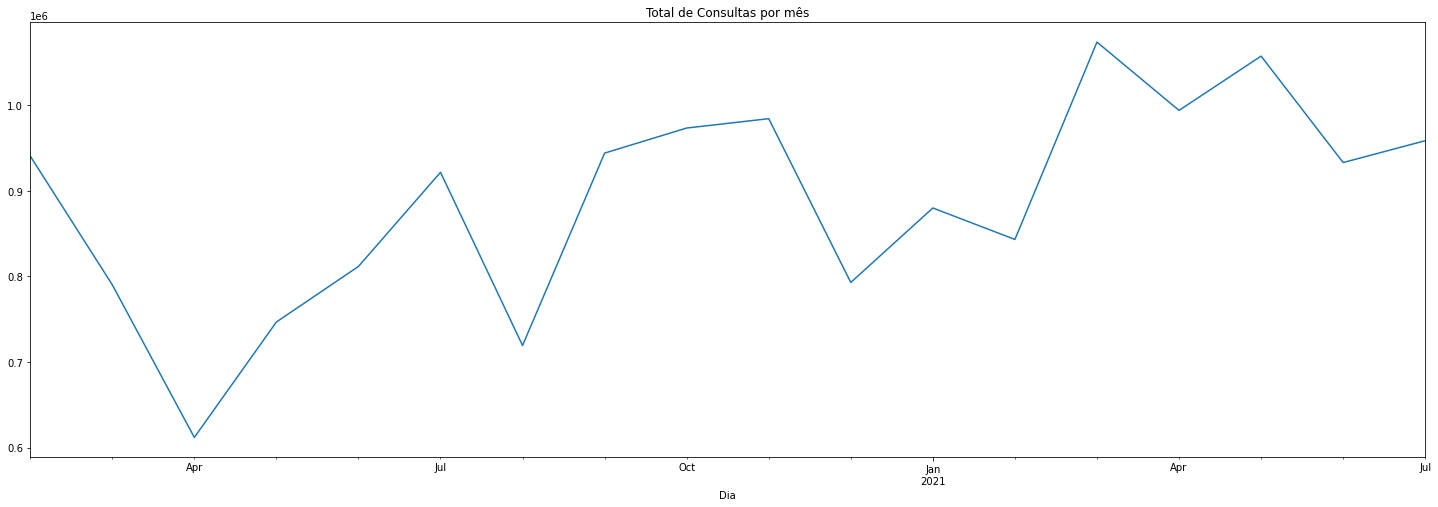

In [24]:
# total de consultas por mês

# desde o início dos dados de COVID
# total_mensal.loc[[d.replace(day=1) for d in total_mensal.index if d >= df_covid.index[0].replace(day=1)]].plot(title="Total de Consultas por mês", figsize=(25,8));

# desde o início dos dados de COVID - R(t)
total_mensal.loc[[d.replace(day=1) for d in total_mensal.index if d >= after_rt_inception[0].replace(day=1)]].plot(title="Total de Consultas por mês", figsize=(25,8));


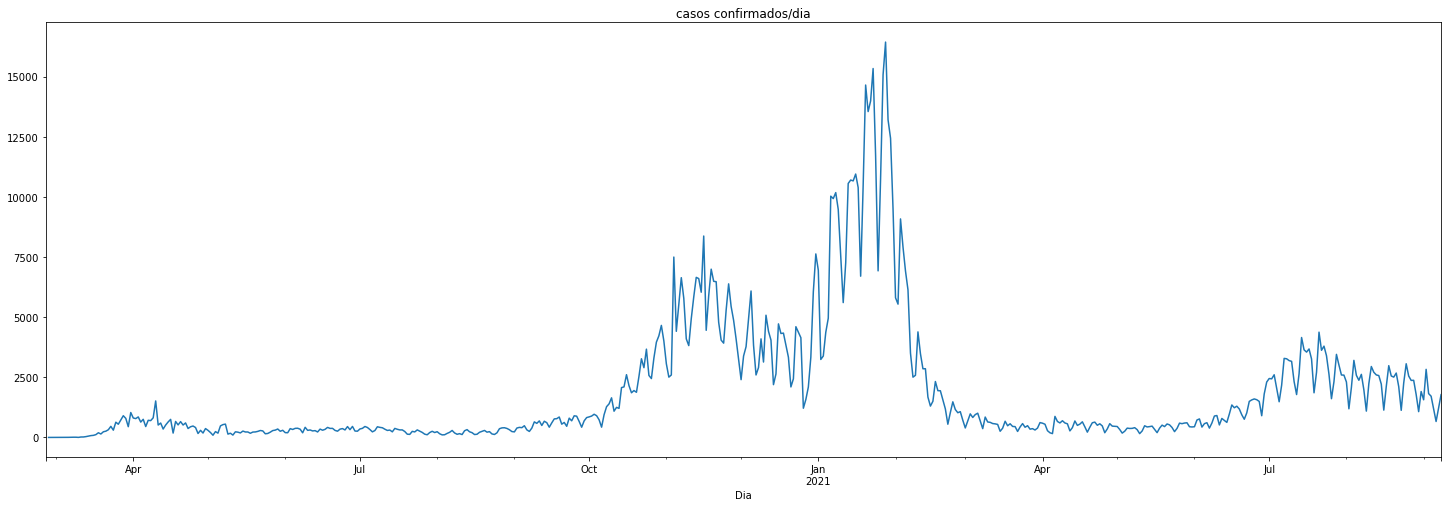

In [16]:
# confirmados por dia
# df_covid.loc[after_rt_inception, "confirmados"].diff().plot(title="casos confirmados/dia", figsize=(25,8));
df_covid.loc[:, "confirmados"].diff().plot(title="casos confirmados/dia", figsize=(25,8));

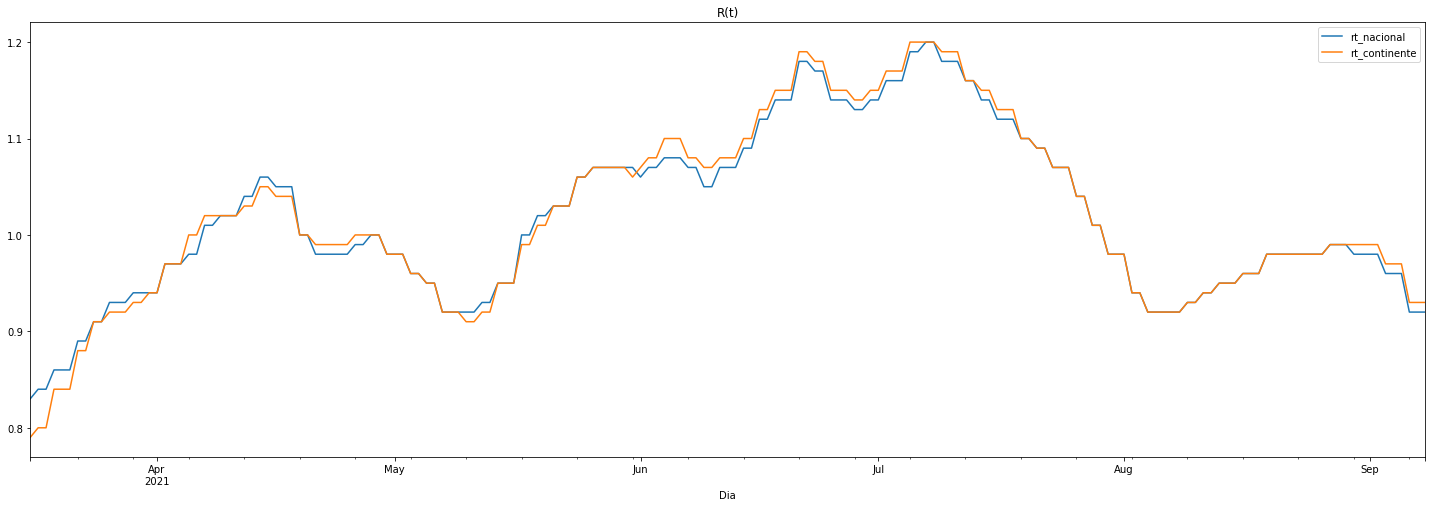

In [17]:
# R(t) por dia
rt_cols = [c for c in df_covid.columns if re.match(r"^rt", c)] # ['rt_nacional', 'rt_continente']
df_covid.loc[after_rt_inception, rt_cols].plot(title="R(t)", figsize=(25,8));

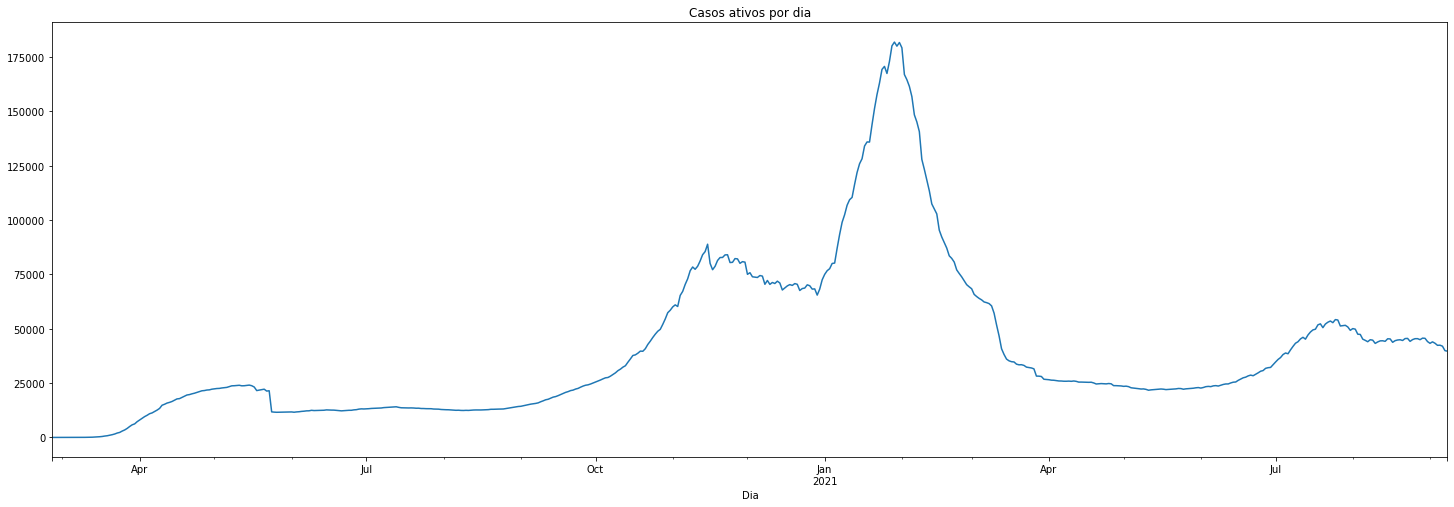

In [18]:
df_covid["ativos"].plot(title="Casos ativos por dia", figsize=(25,8));

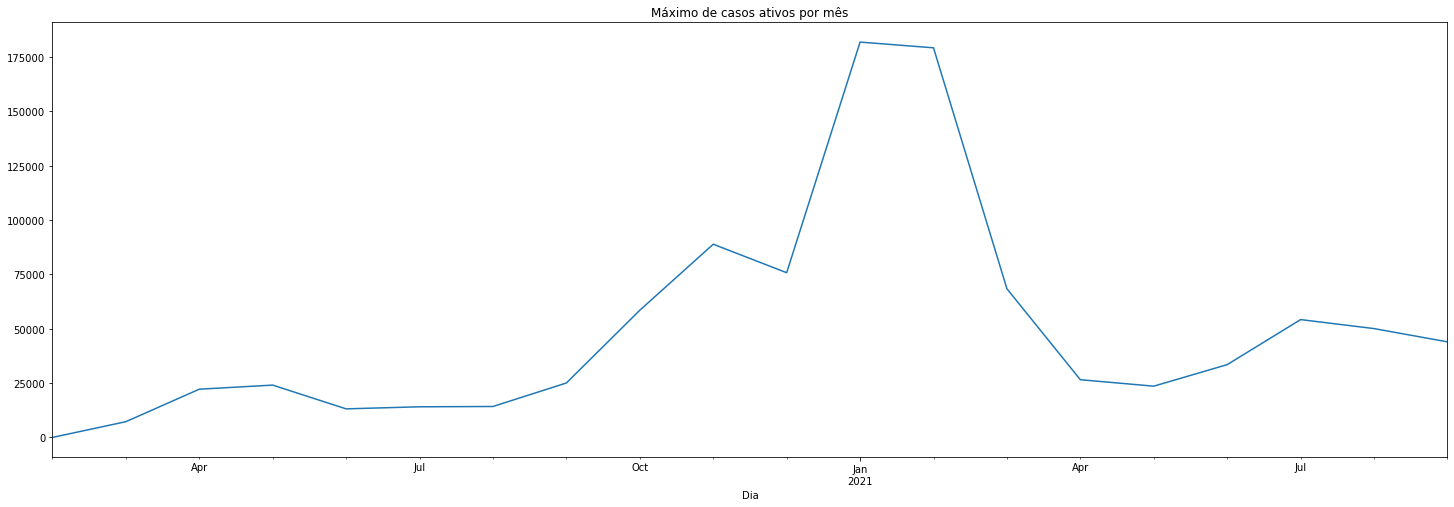

In [19]:
df_covid["ativos"].groupby(pd.Grouper(freq='M')).max().plot(title="Máximo de casos ativos por mês", figsize=(25,8));

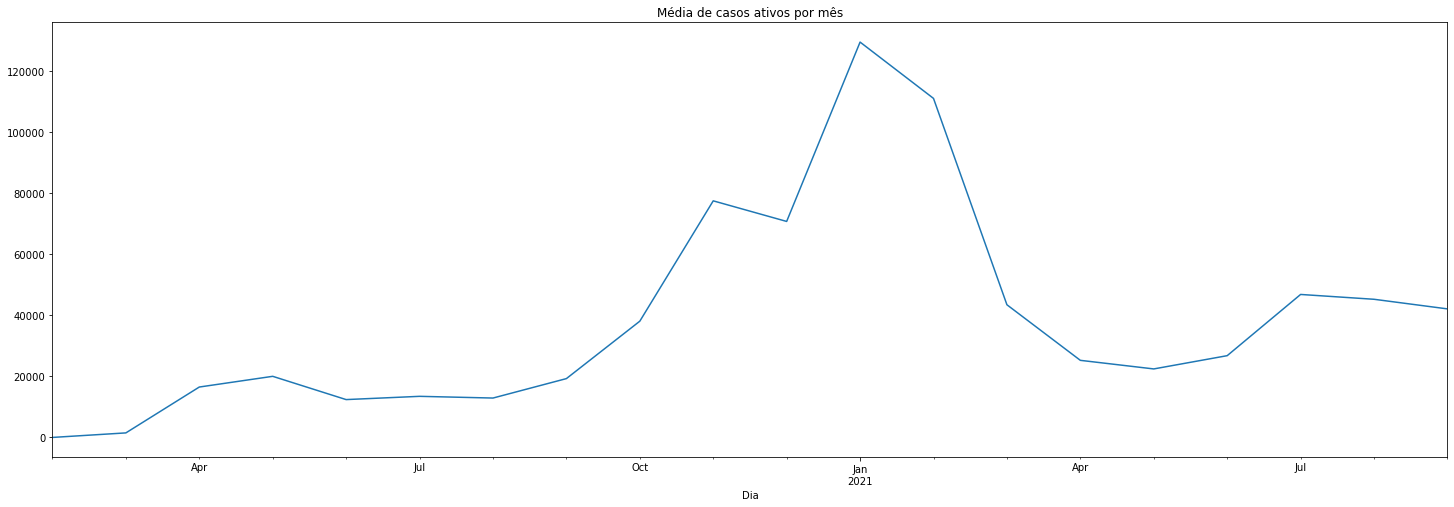

In [20]:
df_covid["ativos"].groupby(pd.Grouper(freq='M')).mean().plot(title="Média de casos ativos por mês", figsize=(25,8));

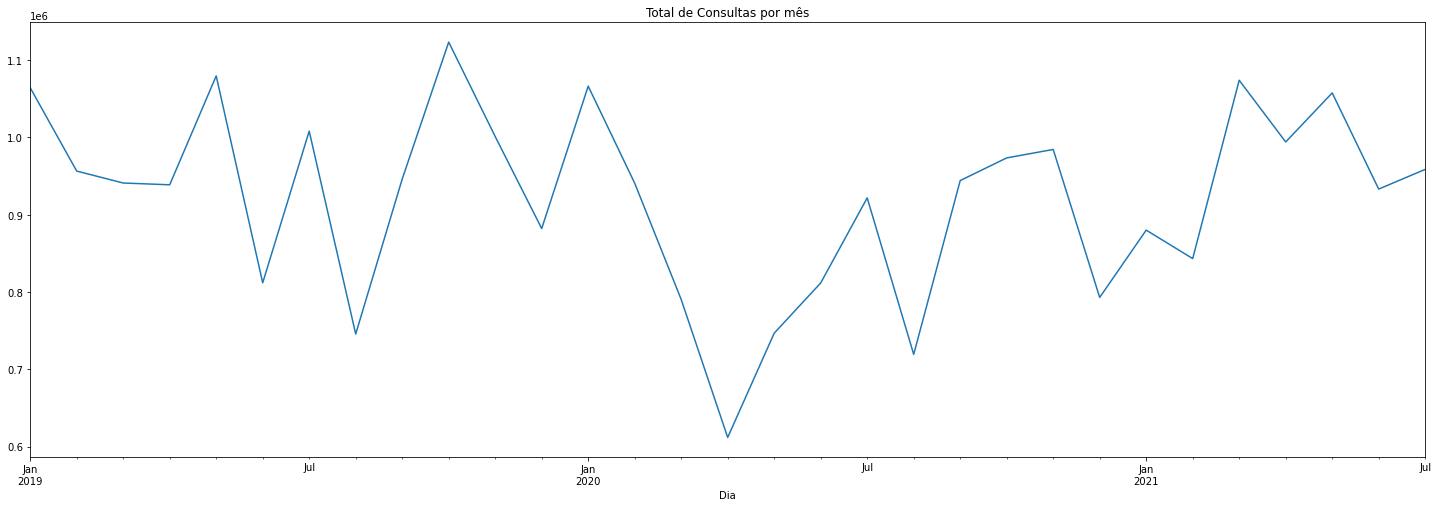

In [21]:
total_mensal.plot(title="Total de Consultas por mês", figsize=(25,8));

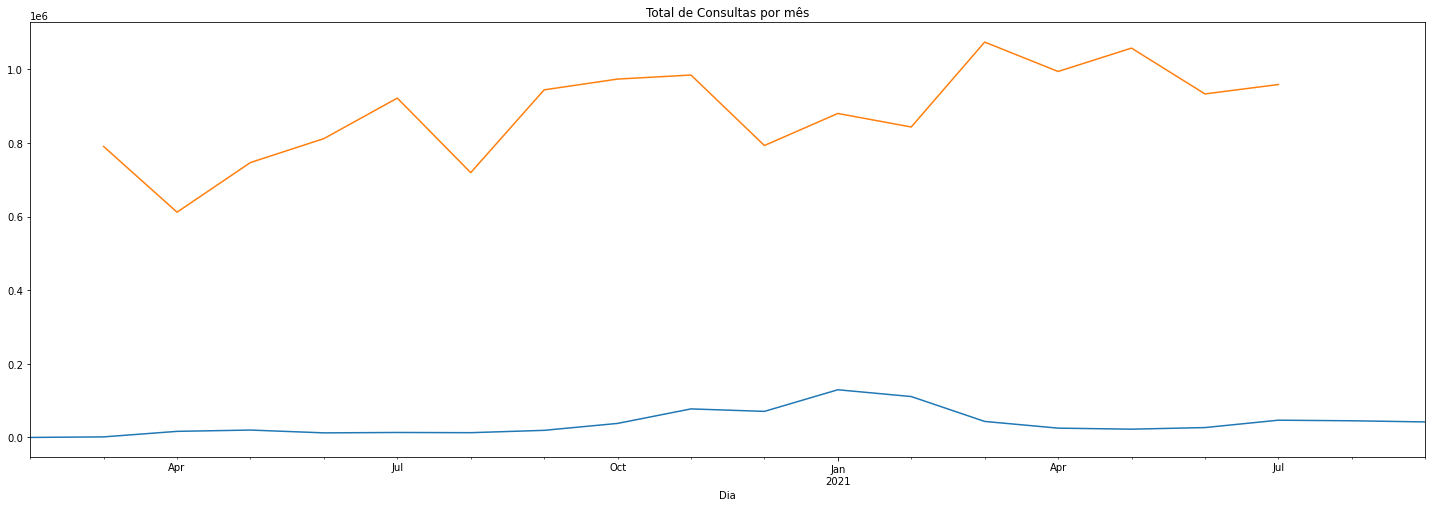

In [22]:
ax = df_covid["ativos"].groupby(pd.Grouper(freq='M')).mean().plot(title="Média de casos ativos por mês", figsize=(25,8))
total_mensal.loc[df_covid.index[0]:].plot(title="Total de Consultas por mês", figsize=(25,8), ax=ax);

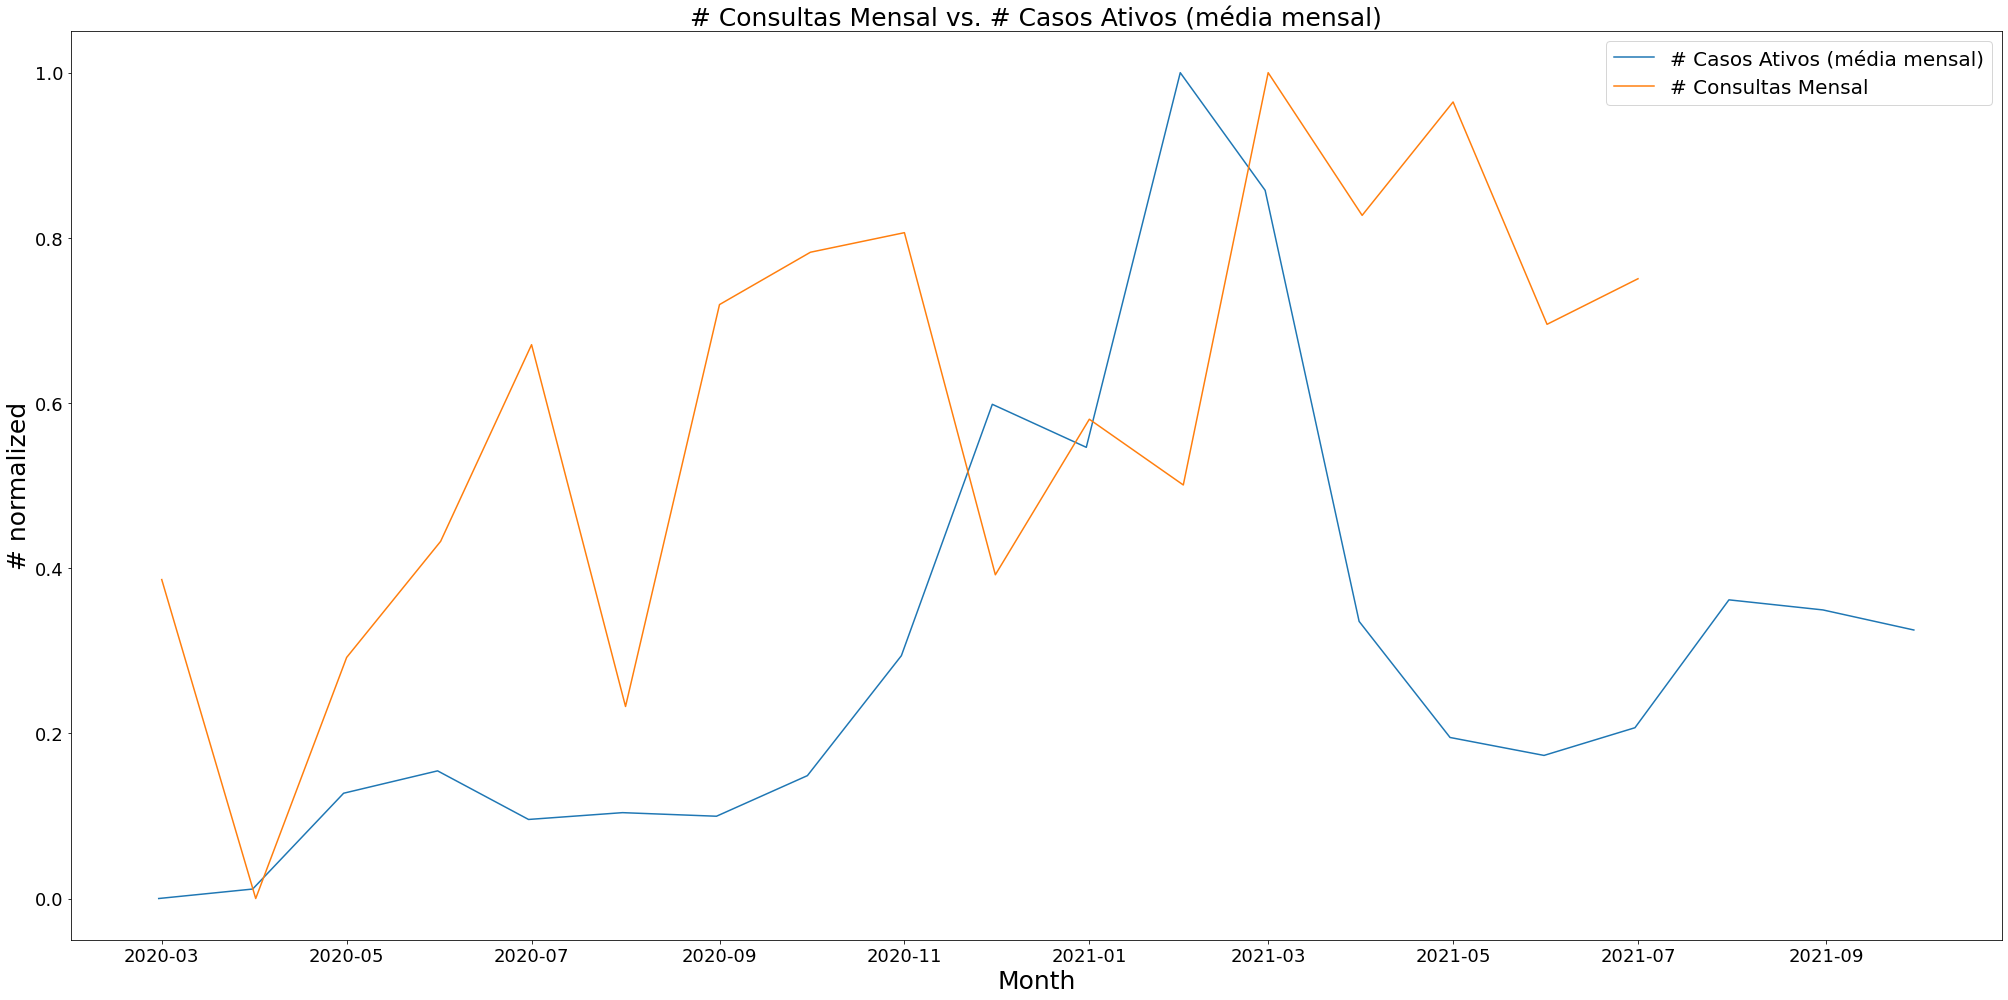

In [23]:
covid_cases = df_covid["ativos"].groupby(pd.Grouper(freq='M')).mean()
appointments = total_mensal.loc[df_covid.index[0]:]

# data normalization
covid_cases = (covid_cases - covid_cases.min()) / (covid_cases.max() - covid_cases.min())
appointments = (appointments - appointments.min()) / (appointments.max() - appointments.min())

fig, ax = plt.subplots(figsize=(28,14))
sns.lineplot(x=covid_cases.index, y=covid_cases, ax=ax)
sns.lineplot(x=appointments.index, y=appointments, ax=ax)
ax.set_xlabel('Month', fontsize=25)
ax.set_ylabel('# normalized', fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(['# Casos Ativos (média mensal)', '# Consultas Mensal'], fontsize=20)
ax.set_title("# Consultas Mensal vs. # Casos Ativos (média mensal)", fontsize=25);
plt.tight_layout()